In [ ]:
# mounting google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# importing all libraries

import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from skimage.measure import shannon_entropy

In [ ]:
# creating an empty csv file

df = pd.DataFrame()
df.to_csv('/content/drive/MyDrive/data.csv')



In [ ]:
# Loading dataset,resizing images

DATASET_DIR = "/content/drive/MyDrive/class 2 x-ray"
OUTPUT_CSV = "/content/drive/MyDrive/data.csv"
VALID_IMAGE_EXTENSIONS = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}
RESIZE_DIM = (768, 768)

CLASS_MAP = {
    "normal": 0,
    "osteoporosis": 1
}

In [ ]:
# reading images

def load_image(file_path):
    return cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

In [2]:
# creating nested triangle masks

def create_nested_triangle_masks(shape, height, iterations=5):
    """
    Creates a series of nested isosceles triangle masks.

    Args:
        shape: (height, width) of the output masks
        height: Height of the largest triangle
        iterations: Number of nested triangles to create

    Returns:
        List of binary masks (uint8 numpy arrays with values 0 or 255)
    """
    masks = []
    center_x = shape[1] // 2
    top_y = (shape[0] - height) // 2  # Center vertically

    # Initial triangle points
    pt1 = (center_x, top_y)  # Top point
    pt2 = (center_x - height//2, top_y + height)  # Bottom left
    pt3 = (center_x + height//2, top_y + height)  # Bottom right

    for i in range(iterations):
        # Create mask for current triangle
        mask = np.zeros(shape, dtype=np.uint8)
        triangle_cnt = np.array([pt1, pt2, pt3])
        cv2.drawContours(mask, [triangle_cnt], 0, 255, -1)
        masks.append(mask)

        # Alternate between splitting left and right sides
        if i % 2 == 0:
            # Split left side - new point between pt1 and pt2
            pt2 = ((pt1[0] + pt2[0])//2, (pt1[1] + pt2[1])//2)
        else:
            # Split right side - new point between pt1 and pt3
            pt3 = ((pt1[0] + pt3[0])//2, (pt1[1] + pt3[1])//2)

    return masks


In [ ]:
# feature extraction

def extract_triangle_features(img):
    """
    Extracts features from nested triangle regions of an image.
    Returns a list of features [mean1, std1, entropy1, mean2, std2, entropy2, ...]
    """
    if len(img.shape) == 3:  # Convert color to grayscale if needed
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    h, w = img.shape

    features = []
    masks = create_nested_triangle_masks((h, w), h, 5)  # Create 5 nested masks

    for mask in masks:
        triangle_pixels = img[mask == 255]

        if len(triangle_pixels) > 0:
            mean_val = np.mean(triangle_pixels)
            std_val = np.std(triangle_pixels)
            entropy_val = shannon_entropy(triangle_pixels)
        else:
            mean_val = std_val = entropy_val = 0.0

        features.extend([mean_val, std_val, entropy_val])

    return features

In [ ]:
# main function

def main():
    all_records = []
    serial_no = 1

    for subfolder in os.listdir(DATASET_DIR):
        subfolder_path = os.path.join(DATASET_DIR, subfolder)
        if os.path.isdir(subfolder_path):
            label = CLASS_MAP.get(subfolder.lower())
            if label is None:
                continue

            for file in tqdm(os.listdir(subfolder_path), desc=f"Processing {subfolder}"):
                if file.lower().endswith(tuple(VALID_IMAGE_EXTENSIONS)):
                    img_path = os.path.join(subfolder_path, file)
                    img = load_image(img_path)
                    if img is None:
                        continue

                    features = extract_triangle_features(img)
                    record = features + [label]
                    all_records.append(record)

                    serial_no += 1

    # Create feature names
    feature_names = []
    for i in range(1, 6):
        feature_names.extend([
            f"mean_{i}", f"std_{i}", f"entropy_{i}"
        ])
    feature_names.append("class")

    df = pd.DataFrame(all_records, columns=feature_names)
    df.to_csv(OUTPUT_CSV, index=False)
    print(f"\n✅ Saved triangle features to {OUTPUT_CSV}")

if __name__ == "__main__":
    main()


Processing Normal: 100%|██████████| 1920/1920 [05:40<00:00,  5.64it/s]


✅ Saved triangle features to /content/drive/MyDrive/data.csv


In [ ]:
print(f"Checking {DATASET_DIR}")
print(f"Subfolders in {DATASET_DIR}: {os.listdir(DATASET_DIR)}")


Checking /content/drive/MyDrive/class 2 x-ray
Subfolders in /content/drive/MyDrive/class 2 x-ray: ['Osteoporosis ', 'Normal ']


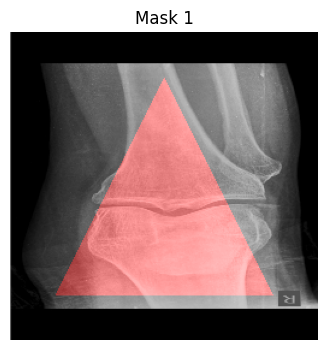

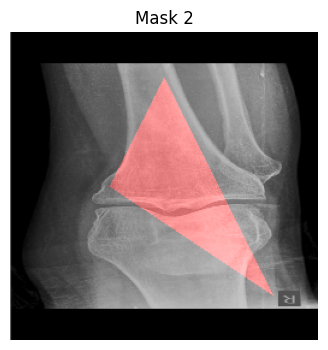

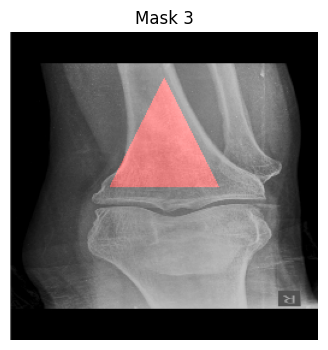

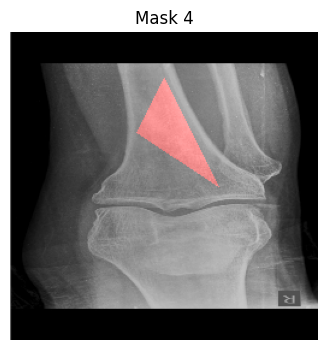

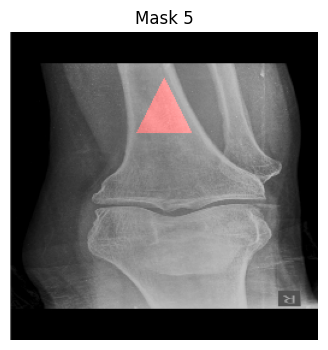

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Read and resize the image
image_path = '/content/drive/MyDrive/Colab Notebooks/sample_img.png'  # Replace with actual path
image = cv2.imread(image_path)
image = cv2.resize(image, (256, 256))  # Use shape suitable for your triangle mask
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Step 2: Generate nested triangle masks
masks = create_nested_triangle_masks(gray_image.shape, height=180, iterations=5)

# Step 3: Overlay masks with transparency and show
for idx, mask in enumerate(masks):
    # Convert single-channel mask to 3 channels
    mask_color = cv2.merge([mask, mask, mask])

    # Give the mask a color (e.g., red)
    colored_mask = np.zeros_like(mask_color)
    colored_mask[:, :, 2] = mask  # Red channel

    # Blend the original image and the colored mask
    blended = cv2.addWeighted(image, 0.8, colored_mask, 0.4, 0)

    # Display result
    plt.figure(figsize=(4, 4))
    plt.title(f'Mask {idx+1}')
    plt.axis('off')
    plt.imshow(cv2.cvtColor(blended, cv2.COLOR_BGR2RGB))
    plt.show()
